In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models

from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/final project')

In [5]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [4]:
def plot_prediction(y_test, y_pred, title, r2, mse, scorr):
  plt.figure(figsize=(8, 8))
  sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
  plt.xlabel('True Values (y_test)')
  plt.ylabel('Predicted Values (y_pred)')
  plt.title(title)
  plt.grid(True)
  plt.figtext(0.75, 0.21, f'MSE: {mse:.3f}', horizontalalignment='left', fontsize=11)
  plt.figtext(0.75, 0.18, f'R\u00B2: {r2:.3f}', horizontalalignment='left', fontsize=11)
  plt.figtext(0.75, 0.15, f'Corr: {scorr:.3f}', horizontalalignment='left', fontsize=11)
  plt.show()

In [6]:
wt = pd.read_csv('WT/WT.csv')
wt.head()

,sgRNA,indel
0,AAAAAAAAACTCCAAAACCCTGG,0.168570
1,AAAAAACAACAAGAAGCACAAGG,0.099624
2,AAAAAACACAAGCAAGACCGTGG,0.247750
3,AAAAAACAGATGCCACCTGTGGG,0.141232
4,AAAAAACCCGTAGATAGCCTCGG,0.045803


In [ ]:
len(wt)

55603

In [7]:
sgRNA_split = wt['sgRNA'].apply(lambda x: list(x))
sgRNA_split = pd.DataFrame(sgRNA_split.tolist())
sgRNA_split.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,A,A,A,A,A,A,A,A,A,C,...,A,A,A,A,C,C,C,T,G,G
1,A,A,A,A,A,A,C,A,A,C,...,A,A,G,C,A,C,A,A,G,G
2,A,A,A,A,A,A,C,A,C,A,...,A,A,G,A,C,C,G,T,G,G
3,A,A,A,A,A,A,C,A,G,A,...,C,A,C,C,T,G,T,G,G,G
4,A,A,A,A,A,A,C,C,C,G,...,A,T,A,G,C,C,T,C,G,G


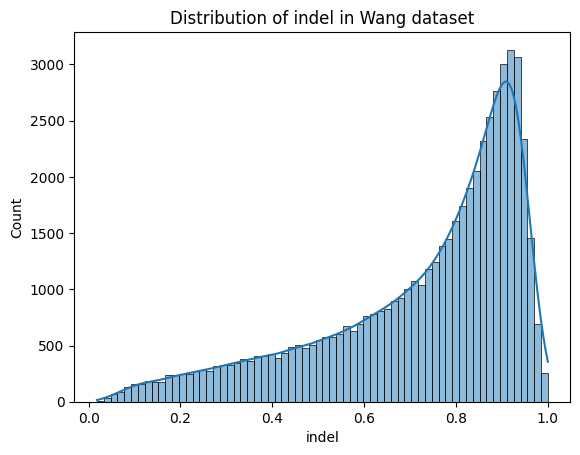

In [ ]:
sns.histplot(wt['indel'], kde=True)
plt.title('Distribution of indel in Wang dataset')
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

sgRNA_split_encoded = sgRNA_split.copy()
label_encoders = {}

for col in sgRNA_split_encoded.columns:
    le = LabelEncoder()
    sgRNA_split_encoded[col] = le.fit_transform(sgRNA_split_encoded[col])
    label_encoders[col] = le

sgRNA_split_encoded = sgRNA_split_encoded.iloc[:, :-2] # Exclude the last two columns
sgRNA_split_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,1,1,1,3
1,0,0,0,0,0,0,1,0,0,1,...,0,2,0,0,2,1,0,1,0,0
2,0,0,0,0,0,0,1,0,1,0,...,2,1,0,0,2,0,1,1,2,3
3,0,0,0,0,0,0,1,0,2,0,...,2,1,1,0,1,1,3,2,3,2
4,0,0,0,0,0,0,1,1,1,2,...,0,2,0,3,0,2,1,1,3,1


In [9]:
sgRNA_label = pd.concat([wt.drop('sgRNA', axis=1), sgRNA_split_encoded], axis=1)
sgRNA_label.head()

,indel,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0.168570,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,1,3
1,0.099624,0,0,0,0,0,0,1,0,0,...,0,2,0,0,2,1,0,1,0,0
2,0.247750,0,0,0,0,0,0,1,0,1,...,2,1,0,0,2,0,1,1,2,3
3,0.141232,0,0,0,0,0,0,1,0,2,...,2,1,1,0,1,1,3,2,3,2
4,0.045803,0,0,0,0,0,0,1,1,1,...,0,2,0,3,0,2,1,1,3,1


In [10]:
from sklearn.model_selection import train_test_split

X = sgRNA_label.drop('indel', axis=1)
y = sgRNA_label['indel']

y_binned = pd.cut(y, bins=10, labels=False, include_lowest=True)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

y_temp_binned = pd.cut(y_temp, bins=10, labels=False, include_lowest=True)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp_binned)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (44482, 21)
y_train shape: (44482,)
X_val shape: (5560, 21)
y_val shape: (5560,)
X_test shape: (5561, 21)
y_test shape: (5561,)


In [11]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f'X_train_reshaped shape: {X_train_reshaped.shape}')
print(f'X_val_reshaped shape: {X_val_reshaped.shape}')
print(f'X_test_reshaped shape: {X_test_reshaped.shape}')

X_train_reshaped shape: (44482, 21, 1)
X_val_reshaped shape: (5560, 21, 1)
X_test_reshaped shape: (5561, 21, 1)


### Model 5: 1D CNN

kernel size 1

In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],), dtype="int64")
embedded = layers.Embedding(input_dim=4, output_dim=16)(inputs)
x = layers.Conv1D(filters=32, kernel_size=1, activation='relu')(embedded)
x = layers.Flatten()(x) # used globalmaximumpooling, the performance was bad, higher dimension might benefit from global pooling but not 16 dimensions.
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 21, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 21, 32)         │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 672)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        43,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,745 (170.88 KB)

 Trainable params: 43,745 (170.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/1DCNN_kernel1.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0413 - val_loss: 0.0233
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0205 - val_loss: 0.0206
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0189 - val_loss: 0.0184
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0178 - val_loss: 0.0178
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0169 - val_loss: 0.0169
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0148 - val_loss: 0.0161
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0146 - val_loss: 0.0182
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0142 - val_loss: 0.0153
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0140 - val_loss: 0.0148
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0136 - val_loss: 0.0148
Epoch 12/200
1

In [ ]:
model = keras.models.load_model("WT/1DCNN_kernel1.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149


0.01450292021036148

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
14,0.013,0.014
15,0.013,0.014
16,0.013,0.016
17,0.013,0.015
18,0.013,0.014


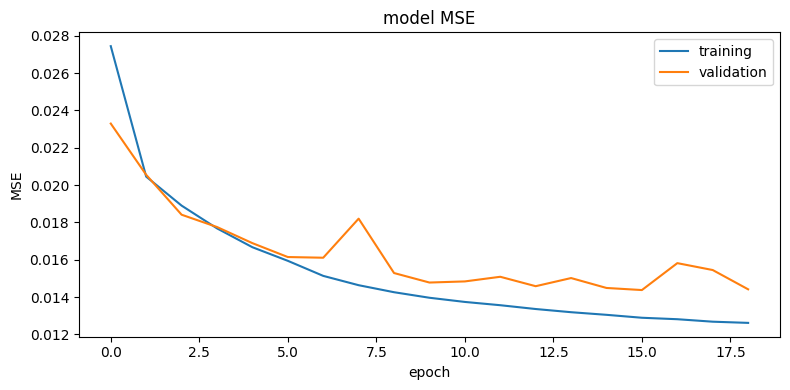

In [ ]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


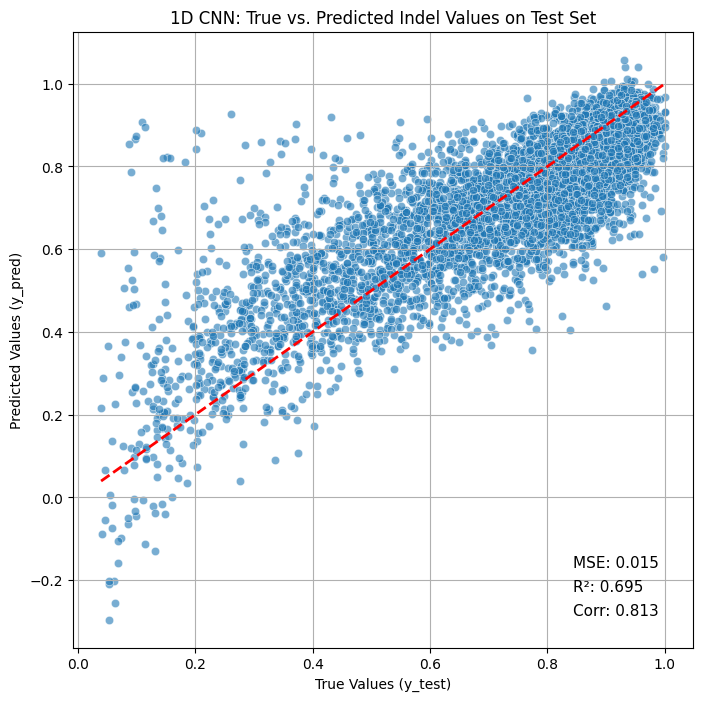

In [ ]:
y_pred_1dcnn = model.predict(X_test_reshaped).flatten()

mse = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2 = r2_score(y_test, y_pred_1dcnn)
scorr = spearmanr(y_test, y_pred_1dcnn).correlation

plot_prediction(y_test, y_pred_1dcnn, title='1D CNN: True vs. Predicted Indel Values on Test Set', r2=r2, mse=mse, scorr=scorr)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred_1dcnn}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 78
       True_Value  Predicted_Value
47133    0.393903         0.774236
37780    0.152561         0.823563
30991    0.372418         0.903641
52291    0.369104         0.674490
42369    0.201679         0.841395


kernel size 3

In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],), dtype="int64")
embedded = layers.Embedding(input_dim=4, output_dim=16)(inputs)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(embedded)
x = layers.Flatten()(x) # used globalmaximumpooling, the performance was bad, higher dimension might benefit from global pooling but not 16 dimensions.
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 21, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 19, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 608)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │        38,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,673 (158.88 KB)

 Trainable params: 40,673 (158.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/1DCNN_kernel3.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0444 - val_loss: 0.0157
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0157 - val_loss: 0.0233
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0145 - val_loss: 0.0204
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0123 - val_loss: 0.0128
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0119 - val_loss: 0.0131
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0115 - val_loss: 0.0144
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0110 - val_loss: 0.0123
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0108 - val_loss: 0.0134
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0106 - val_loss: 0.0120
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0099 - val_loss: 0.0120
Epoch 12/200
1391/

In [ ]:
model = keras.models.load_model("WT/1DCNN_kernel3.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127


0.012595820240676403

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
9,0.011,0.012
10,0.010,0.012
11,0.010,0.012
12,0.009,0.013
13,0.009,0.012


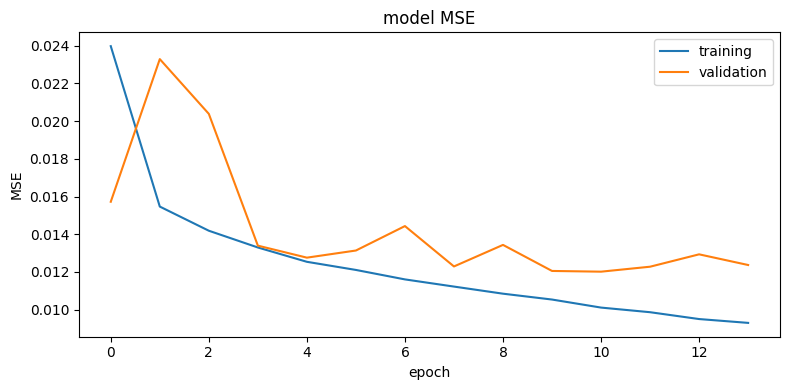

In [ ]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


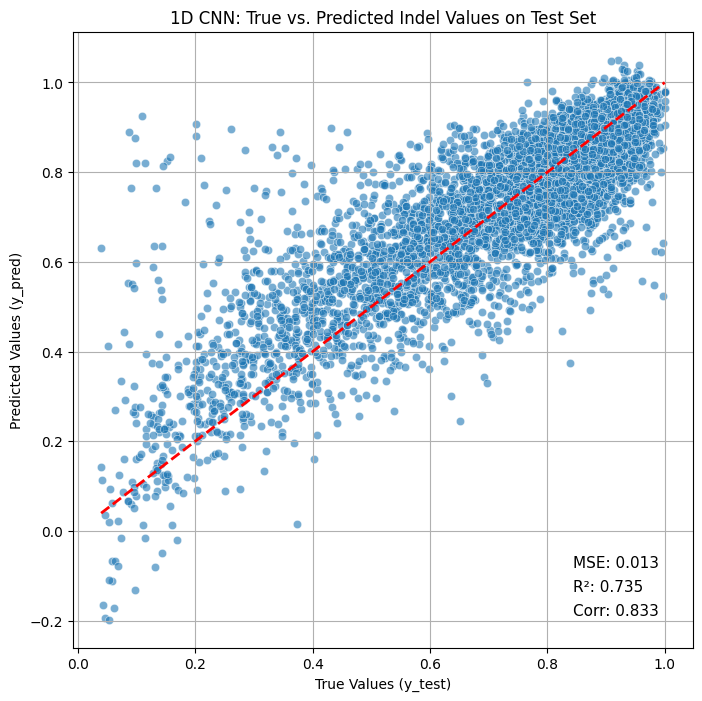

In [ ]:
y_pred_1dcnn = model.predict(X_test_reshaped).flatten()

mse = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2 = r2_score(y_test, y_pred_1dcnn)
scorr = spearmanr(y_test, y_pred_1dcnn).correlation

plot_prediction(y_test, y_pred_1dcnn, title='1D CNN: True vs. Predicted Indel Values on Test Set', r2=r2, mse=mse, scorr=scorr)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred_1dcnn}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 64
       True_Value  Predicted_Value
37780    0.152561         0.824778
30991    0.372418         0.832460
52291    0.369104         0.661414
42369    0.201679         0.906893
51135    0.355050         0.613688


### Model 6: parallel 1D CNN with different kernel size and dilation rate

In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],), dtype="int64")
embedded = layers.Embedding(input_dim=4, output_dim=16)(inputs)

# Parallel Conv1D layers with different kernel size
conv_outputs = []
conv_outputs.append(layers.Conv1D(
    filters=32, kernel_size=2, padding="same", activation="relu")(embedded))
conv_outputs.append(layers.Conv1D(
    filters=32, kernel_size=3, padding="same", activation="relu")(embedded))
conv_outputs.append(layers.Conv1D(
    filters=32, kernel_size=4, padding="same", activation="relu")(embedded))
conv_outputs.append(layers.Conv1D(
    filters=32, kernel_size=5, padding="same", activation="relu")(embedded))
conv_outputs.append(layers.Conv1D(
    filters=32, kernel_size=6, padding="same", activation="relu")(embedded))

x = layers.concatenate(conv_outputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 21, 16)    │         64 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 21, 32)    │      1,056 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 21, 32)    │      1,568 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 21, 32)    │      2,080 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 21, 32)    │      2,592 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 21, 32)    │      3,104 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 21, 160)   │          0 │ conv1d_24[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_25[0][0],  │
│                     │                   │            │ conv1d_26[0][0],  │
│                     │                   │            │ conv1d_27[0][0],  │
│                     │                   │            │ conv1d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3360)      │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3360)      │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │    215,104 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 225,633 (881.38 KB)

 Trainable params: 225,633 (881.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/parallel_1DCNN_kernel.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0341 - val_loss: 0.0180
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0191 - val_loss: 0.0228
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0174 - val_loss: 0.0137
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0165 - val_loss: 0.0181
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0158 - val_loss: 0.0129
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0152 - val_loss: 0.0124
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0145 - val_loss: 0.0126
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0141 - val_loss: 0.0121
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0137 - val_loss: 0.0117
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0133 - val_loss: 0.0117
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0129 - val_loss: 0.01

In [12]:
model = keras.models.load_model("WT/parallel_1DCNN_kernel.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120


0.011754417791962624

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
11,0.013,0.012
12,0.012,0.011
13,0.012,0.012
14,0.012,0.011
15,0.011,0.012


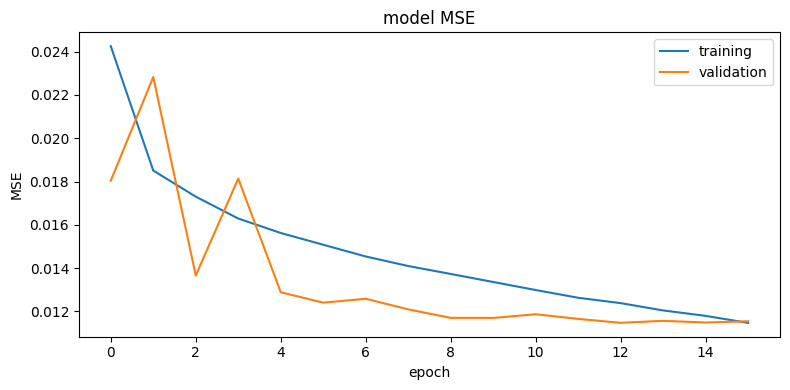

In [ ]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


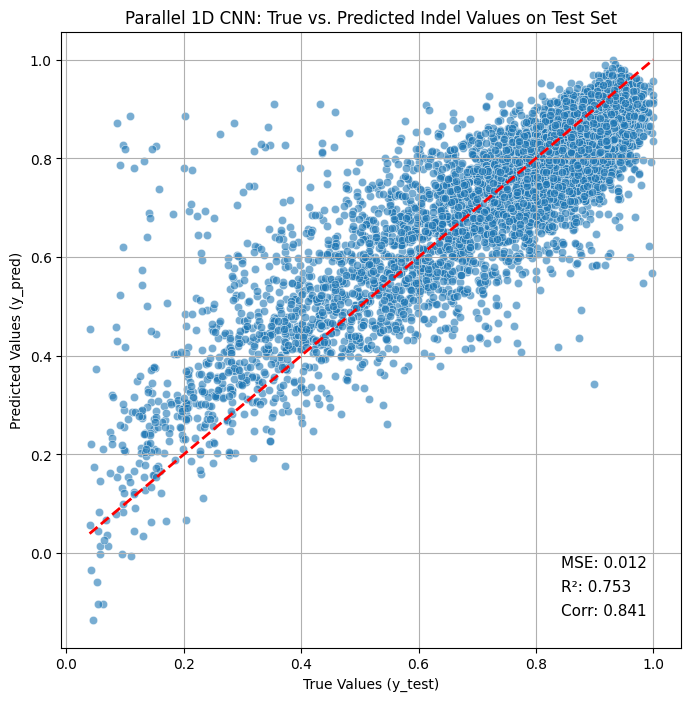

In [ ]:
y_pred_1dcnn = model.predict(X_test_reshaped).flatten()

mse = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2 = r2_score(y_test, y_pred_1dcnn)
scorr = spearmanr(y_test, y_pred_1dcnn).correlation

plot_prediction(y_test, y_pred_1dcnn, title='Parallel 1D CNN: True vs. Predicted Indel Values on Test Set', r2=r2, mse=mse, scorr=scorr)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred_1dcnn}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 65
       True_Value  Predicted_Value
47133    0.393903         0.629800
37780    0.152561         0.825569
30991    0.372418         0.826465
52291    0.369104         0.711883
42369    0.201679         0.884958


Inspect the hidden layer outputs of parallel 1D CNN

In [13]:
layer_name = 'flatten_2'
layer_output = model.get_layer(layer_name).output
intermediate_model = models.Model(
    inputs=model.inputs, outputs=layer_output
)
activations = intermediate_model.predict(X_test_reshaped)

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [14]:
activation_data = {}
for k in range(0,3360):
    activation_data[f"act_val_{k}"] = activations[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
act_val_0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000
act_val_1,0.000,0.087,0.087,0.087,0.087,0.087,0.000,0.000,0.000,0.0,0.0,0.0,0.087,0.000,0.000
act_val_2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000
act_val_3,0.055,0.000,0.000,0.000,0.000,0.000,0.055,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.055
act_val_4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
act_val_3355,0.000,0.079,0.118,0.000,0.000,0.000,0.000,0.079,0.118,0.0,0.0,0.0,0.079,0.000,0.000
act_val_3356,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000
act_val_3357,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000
act_val_3358,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000


In [15]:
from sklearn.manifold import TSNE
import matplotlib as mpl

In [16]:
%%time
tsne = TSNE(n_components=2
            ,init='pca'
            ,learning_rate='auto'
            ,verbose=0
            ,perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(activation_df)

CPU times: user 35.8 s, sys: 145 ms, total: 35.9 s
Wall time: 46.5 s


In [17]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

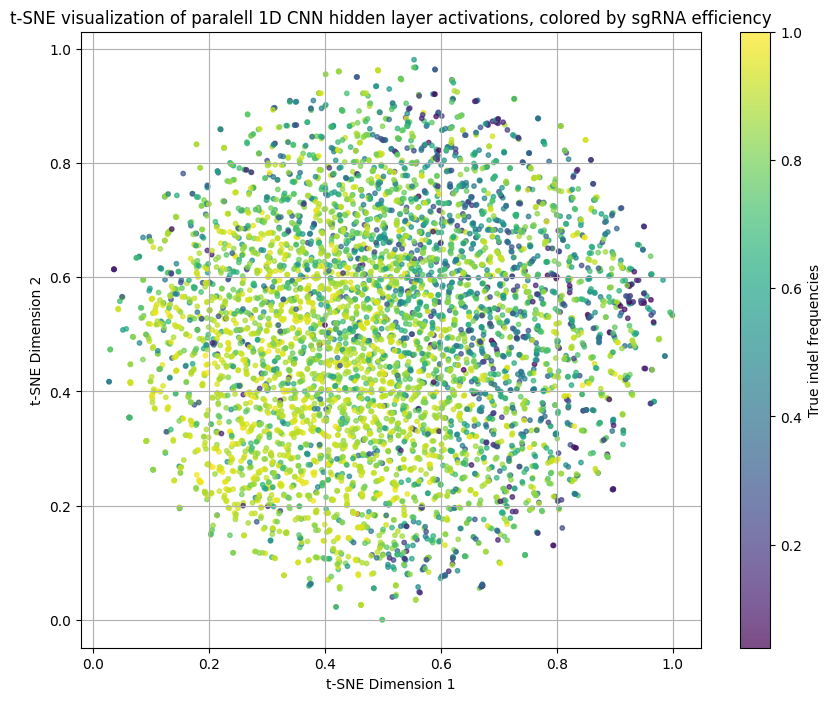

In [18]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, label='True indel frequencies')
plt.title('t-SNE visualization of paralell 1D CNN hidden layer activations, colored by sgRNA efficiency')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()